In [42]:
from selenium import webdriver
import pandas as pd
import nltk
from collections import Counter 
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold
import string
import seaborn as sns
from nltk.tokenize import RegexpTokenizer
#nltk.download('stopwords')
#nltk.download('punkt')
import string
import operator
import io
from selenium.webdriver.common.by import By
import requests
from bs4 import BeautifulSoup
import statsmodels.api as sm
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
import itertools
from sklearn.manifold import MDS
import re


# Scraper Engine

In [10]:
def scrape_page(url):
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, "html.parser")

        messages = soup.find_all("div", class_ = "Message userContent")

        dates = soup.find_all("time")

        data = []

        for message, date in zip(messages, dates):
            message_text = message.get_text(strip = True)
            date_text = date.get("title")
            data.append({"Date": date_text, "Message": message_text})

        return data


def scrape_forum(base_url, total_pages):
    all_data = []

    for page_num in range(1, total_pages + 1):
        page_url = f"{base_url}/p{page_num}"
        print(f"Scraping page {page_num}: {page_url}")
        page_data = scrape_page(page_url)
        all_data.extend(page_data)
    return all_data

In [11]:
base_url = "https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans"
total_pages = 300
forum_data = scrape_forum(base_url, total_pages)
messagedata = pd.DataFrame(forum_data)
messagedata.to_csv("messagedata_final.csv", index = False)
len(messagedata)

Scraping page 1: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p1
Scraping page 2: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p2
Scraping page 3: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p3
Scraping page 4: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p4
Scraping page 5: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p5
Scraping page 6: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p6
Scraping page 7: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p7
Scraping page 8: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p8
Scraping page 9: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p9
S

15001

In [16]:
df = pd.read_csv('messagedata_final.csv')

In [17]:
# Remove messages with empty string
df = df[df['Message'] != '']
#Convert date to MM/DD/YYYY
df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%m/%d/%Y')

In [18]:
df

,Date,Message
0,03/23/2002,Entry level performance luxury sedans are a ho...
1,03/24/2002,I personally think that with a few tweaks the ...
2,03/25/2002,I am debating a new purchase and these two are...
3,03/25/2002,"Great handling, RWD, excellent engine and the ..."
4,03/25/2002,And no manual tranny. That may not matter to y...
...,...,...
14996,01/17/2013,"I would believe the website, not the dealer on..."
14997,01/17/2013,"Wow, the pricing on F30 is simply outrageous.I..."
14998,01/17/2013,dammit!I really thought you guys were talking ...
14999,01/17/2013,"Holy cow! When I did the ""build your own"" for ..."


In [19]:
# Download to CSV
df.to_csv('edmunds_scraper_final.csv', index=False)

## Task A
- Does the data support Zipf’s law econometrically?
- Plot the most common 100 words in the data against the theoretical prediction of the law.

In [23]:
# Does the data support Zipf's law?
# Plot the top 100 words against teoretical Zipf's law
top_words = df['Message'].str.split(expand=True).stack().value_counts()[:100]

top_words

the      72462
a        37960
to       30463
and      29697
I        26600
         ...  
If        1631
see       1623
make      1620
most      1597
could     1562
Name: count, Length: 100, dtype: int64

In [36]:
top_words.head()

the    72462
a      37960
to     30463
and    29697
I      26600
Name: count, dtype: int64

In [37]:
top_word_values = top_words.values

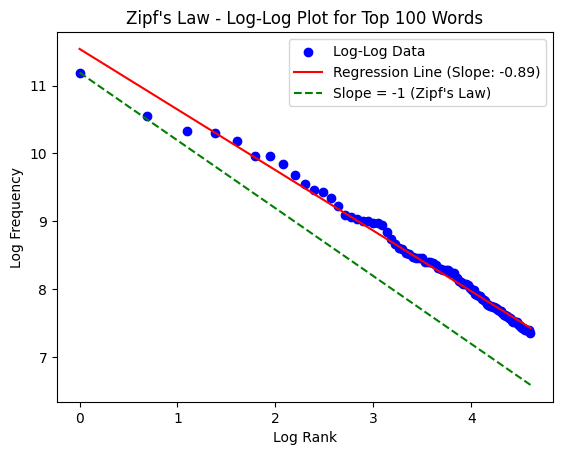

In [39]:
# Finding Ranks and Frequencies
ranks_100 = np.arange(1, len(top_words) + 1)
#print(ranks_100)

# Log Transformations
log_ranks_100 = np.log(ranks_100)
log_frequencies_100 = np.log(top_word_values)

# Econometric Regression
X_100 = sm.add_constant(log_ranks_100)
model_100 = sm.OLS(log_frequencies_100, X_100)
results_100 = model_100.fit()

# Graphing Results 
zipf_line_100 = log_frequencies_100[0] + (-1) * (log_ranks_100 - log_ranks_100[0])

plt.scatter(log_ranks_100, log_frequencies_100, color='blue', label='Log-Log Data')
plt.plot(log_ranks_100, results_100.predict(X_100), color='red', label=f'Regression Line (Slope: {results_100.params[1]:.2f})')
plt.plot(log_ranks_100, zipf_line_100, color='green', linestyle='--', label='Slope = -1 (Zipf\'s Law)')
plt.xlabel('Log Rank')
plt.ylabel('Log Frequency')
plt.title('Zipf\'s Law - Log-Log Plot for Top 100 Words')
plt.legend()
plt.show()

### Does it follow zipf's law?
In summary, the plot econometrically supports Zipf's Law by showing that the relationship between the log of word rank and the log of word frequency is approximately linear with a slope close to -1. This suggests that the dataset follows a power-law distribution, which is consistent with Zipf's Law.

# Task B

In [45]:
mergedmakemodel = pd.read_csv('merged-1.csv')
mergedmakemodel = mergedmakemodel.drop(['Unnamed: 0'], axis = 1)
mergedmakemodel

,make,model
0,acura,cl
1,acura,ilx
2,acura,integra
3,acura,legend
4,acura,mdx
...,...,...
1725,volkswagen,volkwagen
1726,volkswagen,vw
1727,volkswagen,vws
1728,volkswagen,passats


In [49]:
stop_words = set(stopwords.words('english'))
model_to_brand = dict(zip(mergedmakemodel['model'].str.lower(), mergedmakemodel['make'].str.lower()))
brands_set = set(model_to_brand.values())

def replacements(message, model_to_brand, brands_set):
    if not isinstance(message, str):
        message = ''
    words = re.findall(r'\w+', message.lower())
    replaced_words = [model_to_brand.get(word, word) for word in words]
    return set([word for word in replaced_words if word not in stop_words and word in brands_set])

messages = df['Message']
brand_counter = Counter()

for message in messages:
    brands = replacements(message, model_to_brand, brands_set)
    brand_counter.update(brands)

brands_to_remove = ['car', 'sedan', 'problem', 'seat', 'mini']

for brand in brands_to_remove:
    brand_counter.pop(brand, None)

top_10 = brand_counter.most_common(10)

print("Top 10 Brands by Frequency:")
for brand, count in top_10:
    print(f"{brand.capitalize()}: {count}")

Top 10 Brands by Frequency:
Infiniti: 11162
Lexus: 9380
Bmw: 5111
Acura: 3232
Polestar: 2365
Audi: 2234
Honda: 1691
Cadillac: 1319
Toyota: 1000
Nissan: 835


# Task C

In [50]:
from collections import Counter, defaultdict
from itertools import combinations

In [52]:
word_distance_threshold = 7

# Function to check if two brands co-occur within the specified word distance
def brands_co_occur(words, brand_a, brand_b, distance):
    positions_a = [i for i, word in enumerate(words) if word == brand_a]
    positions_b = [i for i, word in enumerate(words) if word == brand_b]
    for pos_a in positions_a:
        for pos_b in positions_b:
            if abs(pos_a - pos_b) <= distance:
                return True
    return False

# Calculate frequencies and co-occurrences
brand_counts = Counter()
pair_counts = defaultdict(int)
total_messages = len(messages)

for message in messages:
    if not isinstance(message, str):
        continue
    words = re.findall(r'\w+', message.lower())
    brands_in_message = [brand for brand in top_10 if brand in words]
    unique_brands = set(brands_in_message)
    
    # Update brand counts
    for brand in unique_brands:
        brand_counts[brand] += 1
    
    # Update pair counts
    for brand_a, brand_b in combinations(unique_brands, 2):
        if brands_co_occur(words, brand_a, brand_b, word_distance_threshold):
            pair_counts[(brand_a, brand_b)] += 1
            pair_counts[(brand_b, brand_a)] += 1  # Count both pairs (A,B) and (B,A)

# Calculate lift for each pair of brands
lifts = {}
for (brand_a, brand_b), co_occurrence_count in pair_counts.items():
    p_a = brand_counts[brand_a] / total_messages
    p_b = brand_counts[brand_b] / total_messages
    p_ab = co_occurrence_count / total_messages
    
    if p_a > 0 and p_b > 0:
        lift = p_ab / (p_a * p_b)
        lifts[(brand_a, brand_b)] = lift

# Print the lift values
print("Lift Ratios for Brand Associations:")
for (brand_a, brand_b), lift in sorted(lifts.items(), key=lambda item: item[1], reverse=True):
    print(f"Lift({brand_a.capitalize()}, {brand_b.capitalize()}) = {lift:.2f}")


Lift Ratios for Brand Associations:
